In [10]:
!sudo apt update
!sudo apt install default-jre -y
!pip install autogluon language_tool_python textstat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.multimodal import MultiModalPredictor
from language_tool_python import LanguageTool
import concurrent.futures
import textstat
from statsmodels.formula.api import ols

train_data = TabularDataset('data/train.csv')
test_data = TabularDataset('data/test.csv')

Hit:1 https://download.docker.com/linux/ubuntu jammy InRelease
Get:2 https://nvidia.github.io/libnvidia-container/stable/ubuntu18.04/amd64  InRelease [1484 B]
Hit:3 https://nvidia.github.io/nvidia-container-runtime/stable/ubuntu18.04/amd64  InRelease
Hit:4 https://packages.microsoft.com/repos/azure-cli jammy InRelease           
Hit:5 http://archive.lambdalabs.com/ubuntu jammy InRelease                     
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]      
Hit:8 https://packages.cloud.google.com/apt cloud-sdk InRelease                
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]        
Hit:10 https://pkg.cloudflare.com/cloudflared jammy InRelease                  
Hit:11 http://ppa.launchpad.net/flexiondotorg/nvtop/ubuntu jammy InRelease     
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease              
Hit:13 https://ppa.launchpadc

Loaded data from: data/train.csv | Columns = 3 / 3 | Rows = 17307 -> 17307
Loaded data from: data/test.csv | Columns = 2 / 2 | Rows = 3 -> 3


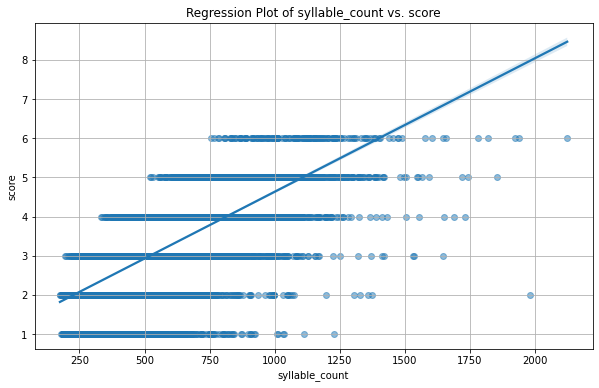

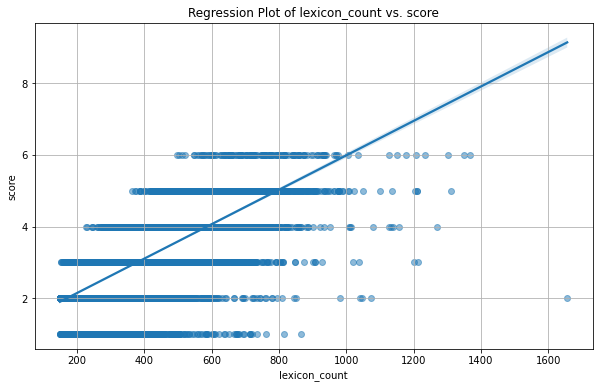

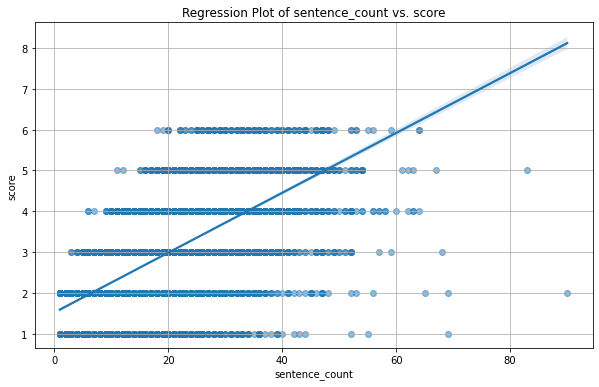

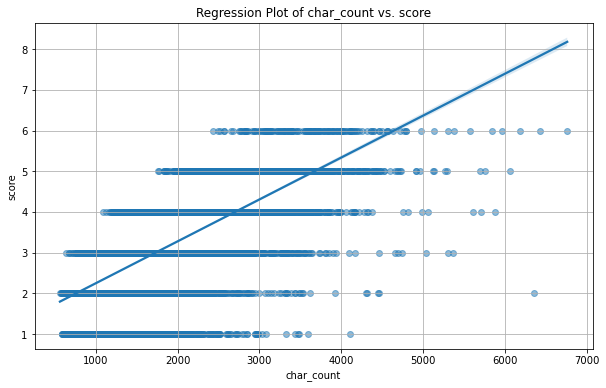

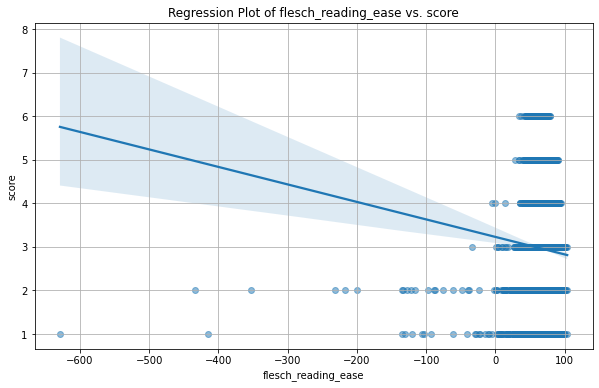

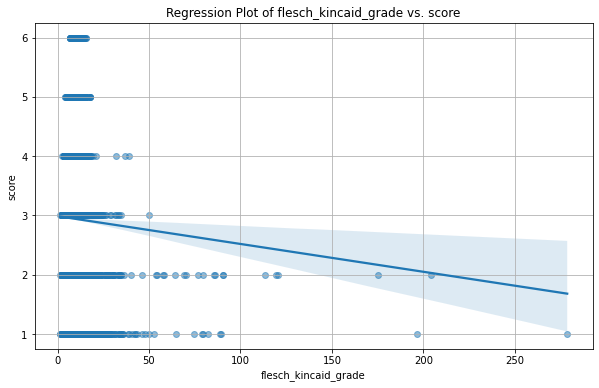

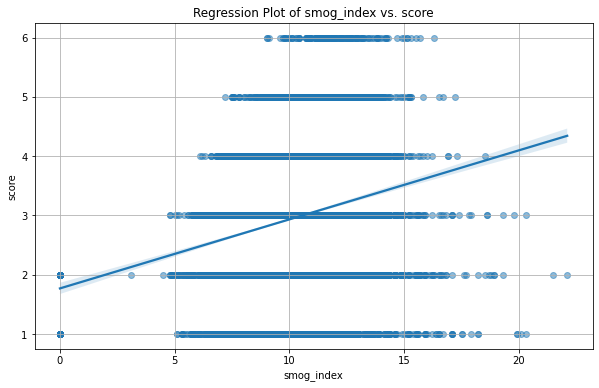

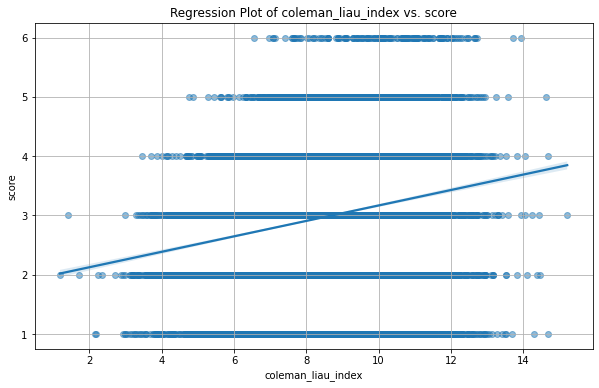

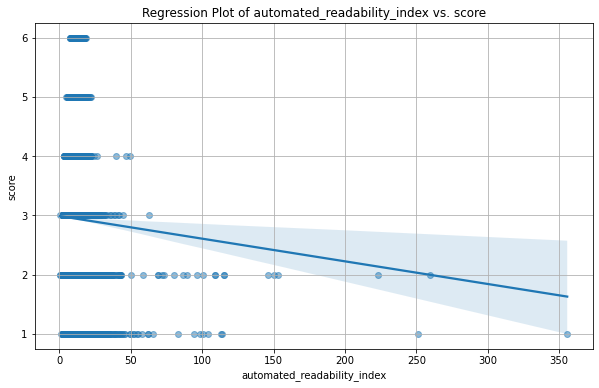

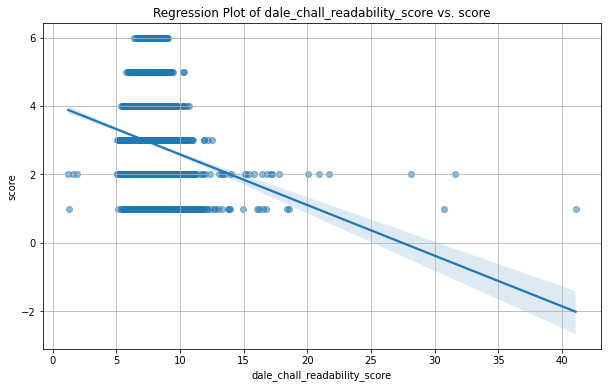

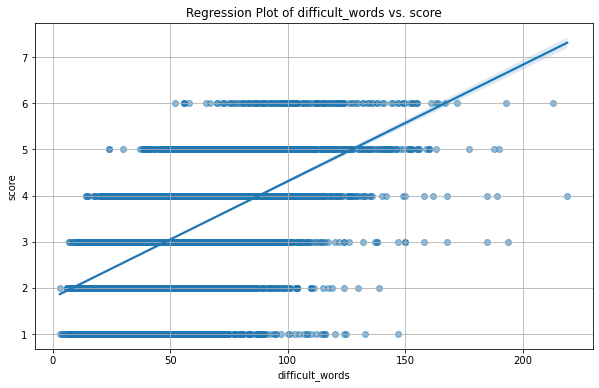

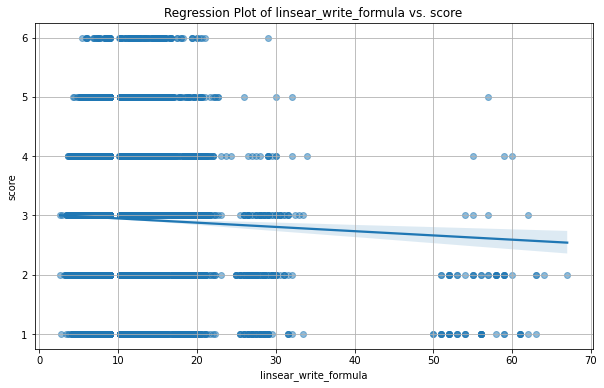

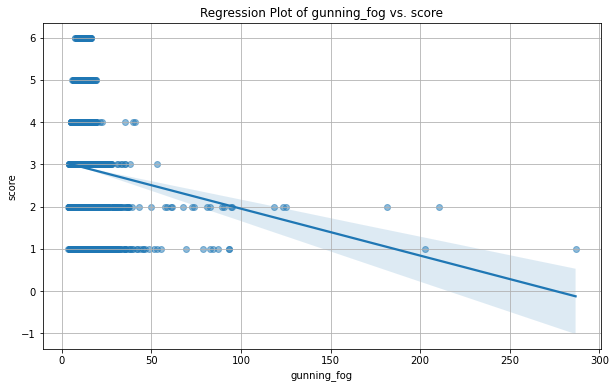

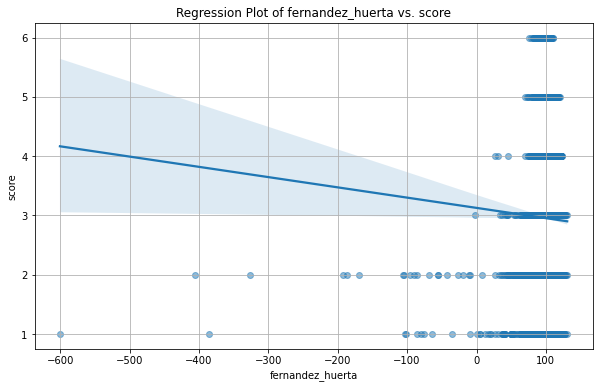

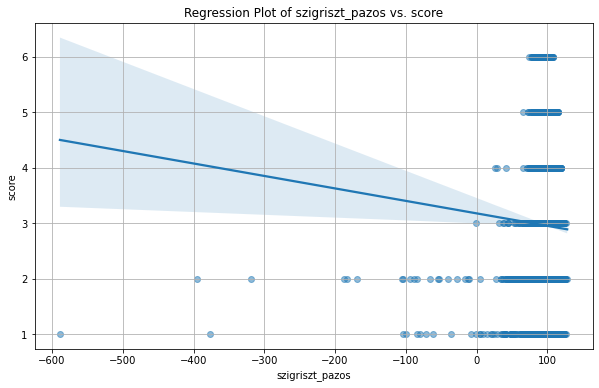

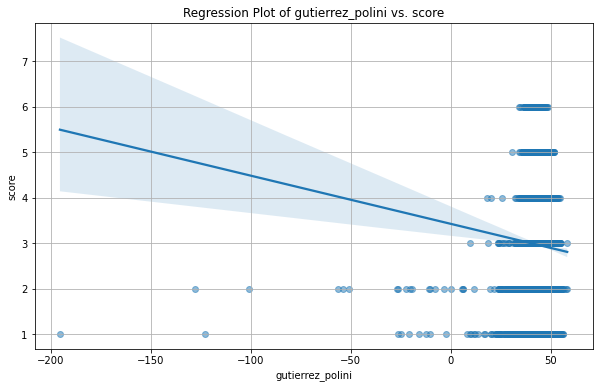

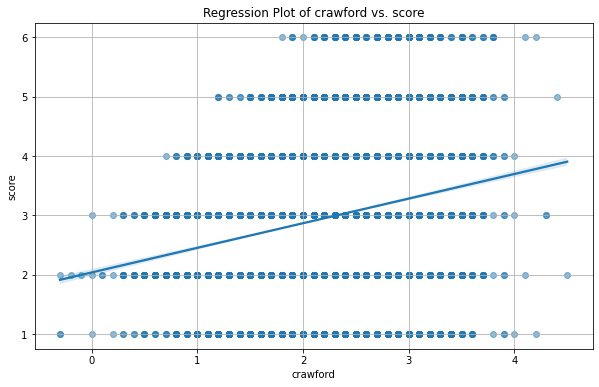

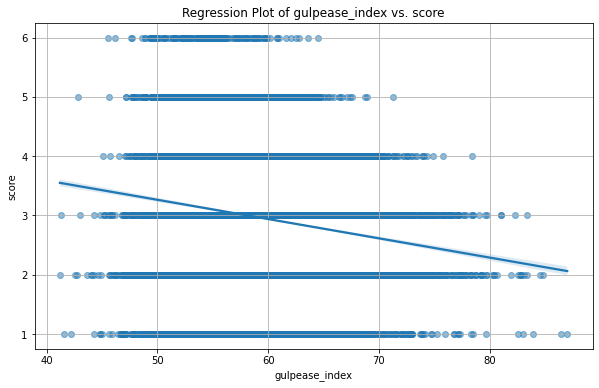

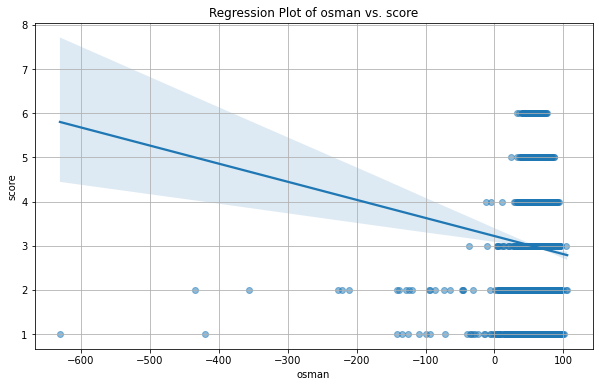

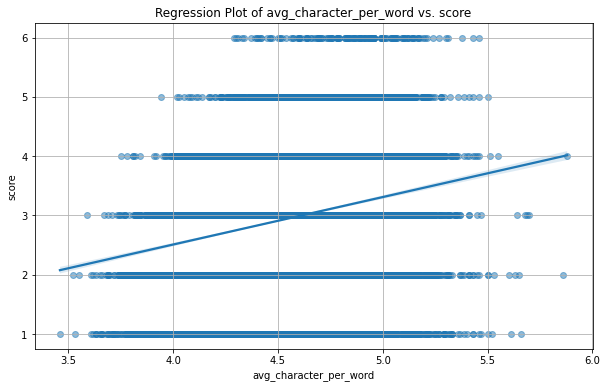

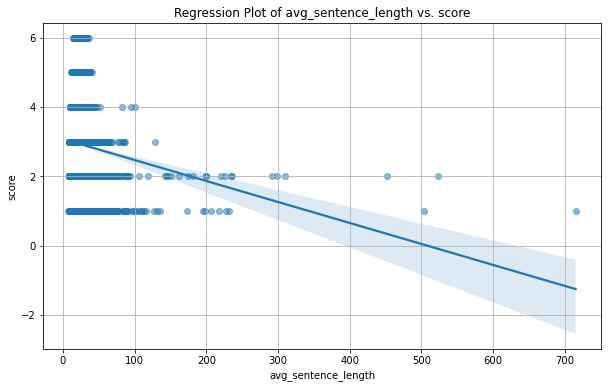

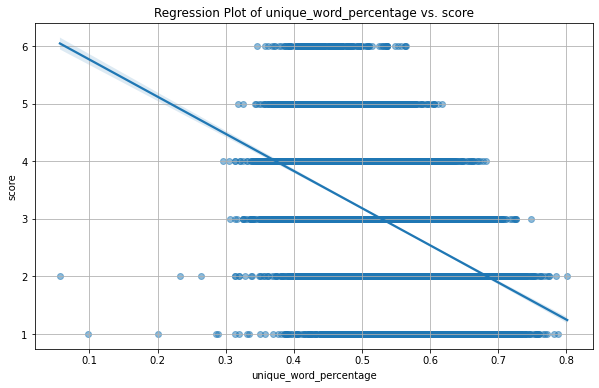

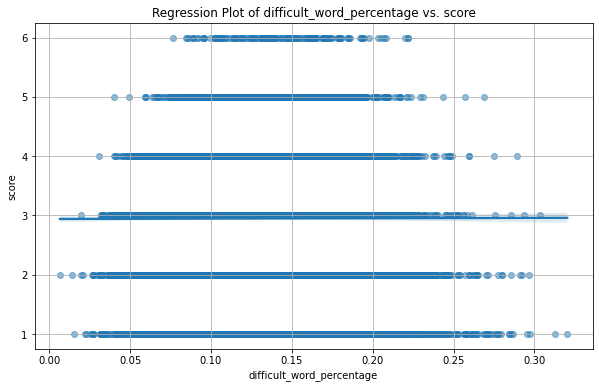

Empty DataFrame
Columns: []
Index: []


In [38]:
def compute_stats_and_plot(data, text_column, score_column):
    stats_methods = {
        'syllable_count': textstat.syllable_count,
        'lexicon_count': textstat.lexicon_count,
        'sentence_count': textstat.sentence_count,
        'char_count': textstat.char_count,

        'flesch_reading_ease': textstat.flesch_reading_ease,
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade,
        'smog_index': textstat.smog_index,
        'coleman_liau_index': textstat.coleman_liau_index,
        'automated_readability_index': textstat.automated_readability_index,
        'dale_chall_readability_score': textstat.dale_chall_readability_score,
        'difficult_words': textstat.difficult_words,
        'linsear_write_formula': textstat.linsear_write_formula,
        'gunning_fog': textstat.gunning_fog,
        'fernandez_huerta': textstat.fernandez_huerta,
        'szigriszt_pazos': textstat.szigriszt_pazos,
        'gutierrez_polini': textstat.gutierrez_polini,
        'crawford': textstat.crawford,
        'gulpease_index': textstat.gulpease_index,
        'osman': textstat.osman,

        'avg_character_per_word': textstat.avg_character_per_word,
        'avg_sentence_length': textstat.avg_sentence_length,

        'unique_word_percentage': lambda x: len(set(x.split())) / len(x.split()),
        'difficult_word_percentage': lambda x: textstat.difficult_words(x) / textstat.lexicon_count(x),
    }
    
    p_values = {}

    for name, func in stats_methods.items():
        data[name] = data[text_column].apply(func)
        
        plt.figure(figsize=(10, 6))
        sns.regplot(data=data, x=name, y=score_column, scatter_kws={'alpha':0.5})
        plt.title(f'Regression Plot of {name} vs. {score_column}')
        plt.xlabel(name)
        plt.ylabel(score_column)
        plt.grid(True)
        plt.show()
    
    return p_values

# Example usage
p_values = compute_stats_and_plot(train_data, 'full_text', 'score')
print(pd.DataFrame(p_values))

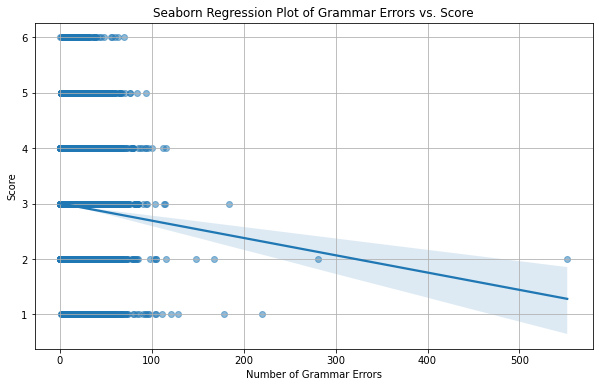

In [40]:
lt = LanguageTool('en-US')

def count_grammar_errors(text):
    matches = lt.check(text)
    return len(matches)

def apply_parallel(df, func):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(func, df['full_text']))
    return results

train_data['grammar_errors'] = apply_parallel(train_data, count_grammar_errors)

plt.figure(figsize=(10, 6))
sns.regplot(data=train_data, x='grammar_errors', y='score', scatter_kws={'alpha':0.5})
plt.title('Seaborn Regression Plot of Grammar Errors vs. Score')
plt.xlabel('Number of Grammar Errors')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [5]:
predictor = MultiModalPredictor(label='score', eval_metric='quadratic_kappa').fit(train_data=train_data[['score', 'full_text']])

No path specified. Models will be saved in: "AutogluonModels/ag-20240416_033357"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #38~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov  2 18:01:13 UTC 2
CPU Count:          30
Pytorch Version:    2.0.1
CUDA Version:       12.2
Memory Avail:       177.90 GB / 196.56 GB (90.5%)
Disk Space Avail:   8589934570.05 GB / 8589934592.00 GB (100.0%)
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	6 unique label values:  [3, 4, 2, 1, 5, 6]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 60: 'val_quadratic_kappa' reached 0.70543 (best 0.70543), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_033357/epoch=0-step=60.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 121: 'val_quadratic_kappa' reached 0.73939 (best 0.73939), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_033357/epoch=0-step=121.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 182: 'val_quadratic_kappa' reached 0.73799 (best 0.73939), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_033357/epoch=1-step=182.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 243: 'val_quadratic_kappa' reached 0.79876 (best 0.79876), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_033357/epoch=1-step=243.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 304: 'val_quadratic_kappa' reached 0.78610 (best 0.79876), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_033357/epoch=2-step=304.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 365: 'val_quadratic_kappa' reached 0.79030 (best 0.79876), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_033357/epoch=2-step=365.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 426: 'val_quadratic_kappa' reached 0.79999 (best 0.79999), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_033357/epoch=3-step=426.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 487: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 548: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 609: 'val_quadratic_kappa' reached 0.79886 (best 0.79999), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_033357/epoch=4-step=609.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 670: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 731: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 792: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 853: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 914: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 975: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1036: 'val_quadratic_kappa' was not in top 3
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/home/ubuntu/fs/AutogluonModels/ag-20240416_033357")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [6]:
predictor_len = MultiModalPredictor(label='score', eval_metric='quadratic_kappa').fit(train_data=train_data[['score', 'full_text', 'lexicon_count']])

No path specified. Models will be saved in: "AutogluonModels/ag-20240416_050040"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #38~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov  2 18:01:13 UTC 2
CPU Count:          30
Pytorch Version:    2.0.1
CUDA Version:       12.2
Memory Avail:       173.66 GB / 196.56 GB (88.3%)
Disk Space Avail:   8589934562.28 GB / 8589934592.00 GB (100.0%)
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	6 unique label values:  [3, 4, 2, 1, 5, 6]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 60: 'val_quadratic_kappa' reached 0.66140 (best 0.66140), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_050040/epoch=0-step=60.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 121: 'val_quadratic_kappa' reached 0.75555 (best 0.75555), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_050040/epoch=0-step=121.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 182: 'val_quadratic_kappa' reached 0.78374 (best 0.78374), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_050040/epoch=1-step=182.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 243: 'val_quadratic_kappa' reached 0.80119 (best 0.80119), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_050040/epoch=1-step=243.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 304: 'val_quadratic_kappa' reached 0.77613 (best 0.80119), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_050040/epoch=2-step=304.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 365: 'val_quadratic_kappa' reached 0.78967 (best 0.80119), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_050040/epoch=2-step=365.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 426: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 487: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 548: 'val_quadratic_kappa' reached 0.79218 (best 0.80119), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_050040/epoch=4-step=548.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 609: 'val_quadratic_kappa' reached 0.79147 (best 0.80119), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_050040/epoch=4-step=609.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 670: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 731: 'val_quadratic_kappa' reached 0.79771 (best 0.80119), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_050040/epoch=5-step=731.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 792: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 853: 'val_quadratic_kappa' reached 0.79639 (best 0.80119), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_050040/epoch=6-step=853.ckpt' as top 3
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/home/ubuntu/fs/AutogluonModels/ag-20240416_050040")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [7]:
predictor_len_gram = MultiModalPredictor(label='score', eval_metric='quadratic_kappa').fit(train_data=train_data[['score', 'full_text', 'lexicon_count', 'grammar_errors']])

No path specified. Models will be saved in: "AutogluonModels/ag-20240416_053833"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #38~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov  2 18:01:13 UTC 2
CPU Count:          30
Pytorch Version:    2.0.1
CUDA Version:       12.2
Memory Avail:       170.78 GB / 196.56 GB (86.9%)
Disk Space Avail:   8589934571.28 GB / 8589934592.00 GB (100.0%)
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	6 unique label values:  [3, 4, 2, 1, 5, 6]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 60: 'val_quadratic_kappa' reached 0.73160 (best 0.73160), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_053833/epoch=0-step=60.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 121: 'val_quadratic_kappa' reached 0.77335 (best 0.77335), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_053833/epoch=0-step=121.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 182: 'val_quadratic_kappa' reached 0.77415 (best 0.77415), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_053833/epoch=1-step=182.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 243: 'val_quadratic_kappa' reached 0.78148 (best 0.78148), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_053833/epoch=1-step=243.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 304: 'val_quadratic_kappa' reached 0.77914 (best 0.78148), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_053833/epoch=2-step=304.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 365: 'val_quadratic_kappa' reached 0.80469 (best 0.80469), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_053833/epoch=2-step=365.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 426: 'val_quadratic_kappa' reached 0.80741 (best 0.80741), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_053833/epoch=3-step=426.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 487: 'val_quadratic_kappa' reached 0.79715 (best 0.80741), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_053833/epoch=3-step=487.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 548: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 609: 'val_quadratic_kappa' reached 0.80537 (best 0.80741), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_053833/epoch=4-step=609.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 670: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 731: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 792: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 853: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 914: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 975: 'val_quadratic_kappa' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1036: 'val_quadratic_kappa' was not in top 3
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/home/ubuntu/fs/AutogluonModels/ag-20240416_053833")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [8]:
predictor_len_gram_noMM = TabularPredictor(label='score', eval_metric='quadratic_kappa').fit(train_data=train_data[['score', 'full_text', 'lexicon_count', 'grammar_errors']])

No path specified. Models will be saved in: "AutogluonModels/ag-20240416_062211"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240416_062211"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #38~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov  2 18:

In [ ]:
predictor_len_gram = MultiModalPredictor(label='score', eval_metric='quadratic_kappa').fit(
    train_data=train_data[[
        'score',
        'full_text',
        'syllable_count',
        'lexicon_count',
        'sentence_count',
        'grammar_errors',
        'char_count',
        'smog_index',
        'coleman_liau_index',
        'difficult_words',
        'crawford',
        'avg_character_per_word',
        'avg_sentence_length',
        'unique_word_percentage',
        'difficult_word_percentage'
    ]]
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240416_083351"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #38~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov  2 18:01:13 UTC 2
CPU Count:          30
Pytorch Version:    2.0.1
CUDA Version:       12.2
Memory Avail:       169.24 GB / 196.56 GB (86.1%)
Disk Space Avail:   8589934565.46 GB / 8589934592.00 GB (100.0%)
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	6 unique label values:  [3, 4, 2, 1, 5, 6]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 60: 'val_quadratic_kappa' reached 0.70306 (best 0.70306), saving model to '/home/ubuntu/fs/AutogluonModels/ag-20240416_083351/epoch=0-step=60.ckpt' as top 3
